In [1]:
from ModMNIST import ModMNIST
from MNISTExperiment import *
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
torch.manual_seed(43)

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [4]:
label_filter = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
trainset = ModMNIST(train=True, filt_labels=label_filter)
testset = ModMNIST(train=False, filt_labels=label_filter)

BATCH_SIZE = 1024

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
fc_output_size = testloader.dataset.labels.max().item() + 1
print(f'fully connected layer output size: {fc_output_size}')

fully connected layer output size: 40


In [6]:
def get_after_conv_data(model, dataloader):
    activation = {}

    def getActivation(name):
        # the hook signature
        def hook(model, input, output):
            activation[name] = output.cpu().detach()
        return hook
    
    data = []
    hook = model.conv[2].register_forward_hook(getActivation('conv'))
    model.eval()
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x = x.to(device)
            y = y.to(device)
            out = model(x)
            data.append(activation['conv'].flatten())
    hook.remove()
    
    return torch.cat(data)

In [7]:
CONV_OUT_CHANNEL_SIZE = 10

modelWithoutPooling = CNN(conv_out_channels=CONV_OUT_CHANNEL_SIZE, conv_kernel_size=2, fc_out_size=fc_output_size, batch_size=BATCH_SIZE).to(device)
exp1 = MNISTExperiment(filtered_labels=label_filter, trainloader=trainloader, testloader=testloader, model=modelWithoutPooling, fc_out_size=fc_output_size, print_grad=True)

100%|██████████| 5/5 [00:32<00:00,  6.58s/it]


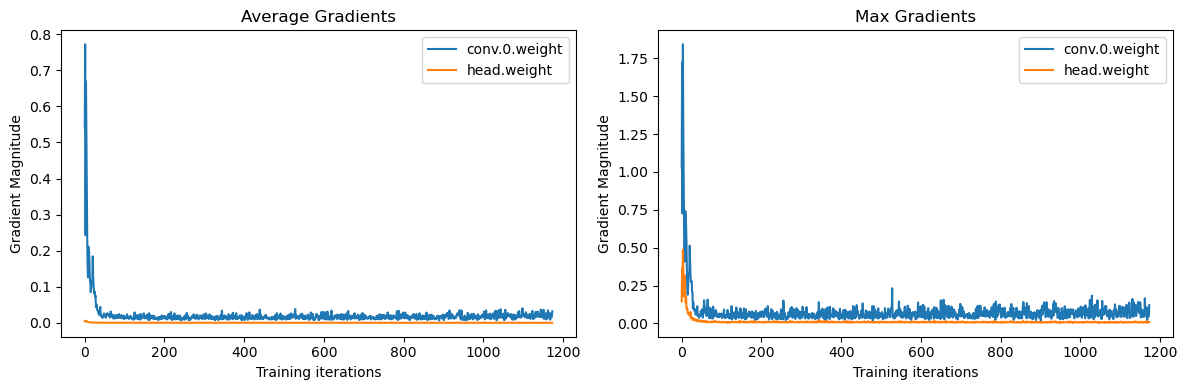

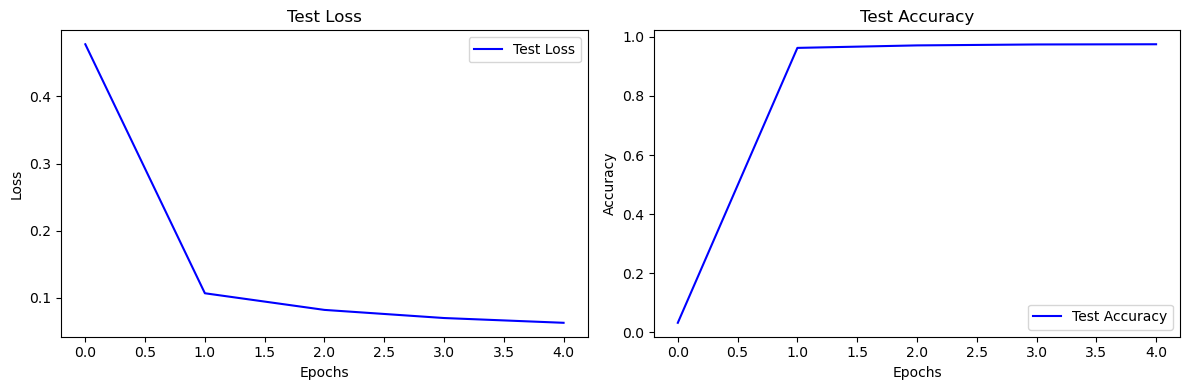

In [8]:
exp1.run(epochs=5)

accuracy on classes: 0.977575, accuracy on positions: 1.0


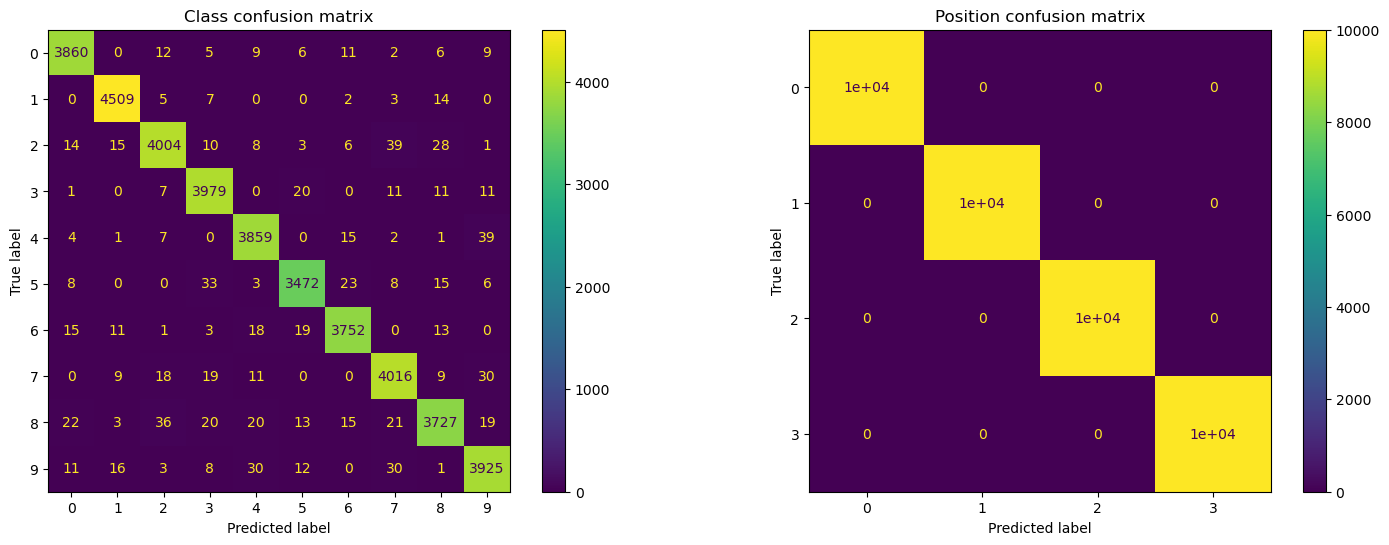

In [9]:
exp1.display_confusion_matrices()

In [10]:
conv_output_data = get_after_conv_data(modelWithoutPooling, testloader)

print(f'max: {conv_output_data.max()}, min: {conv_output_data.min()}, mean: {conv_output_data.mean()}, std: {conv_output_data.std()}')

max: 4.598283767700195, min: 0.0, mean: 0.04870176315307617, std: 0.24025681614875793


In [11]:
modelWithPooling = CNNWithPooling(conv_out_channels=CONV_OUT_CHANNEL_SIZE, conv_kernel_size=2, pool_size=None, pooling=torch.nn.AvgPool2d, fc_out_size=fc_output_size, batch_size=BATCH_SIZE).to(device)
modelWithPooling.conv[0] = modelWithoutPooling.conv[0]
modelWithPooling.conv[1] = modelWithoutPooling.conv[1]
modelWithPooling.conv.apply(lambda m: set_requires_grad(m, False))

exp2 = MNISTExperiment(filtered_labels=label_filter, trainloader=trainloader, testloader=testloader, model=modelWithPooling, fc_out_size=fc_output_size, print_grad=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:44<00:00,  4.05s/it]


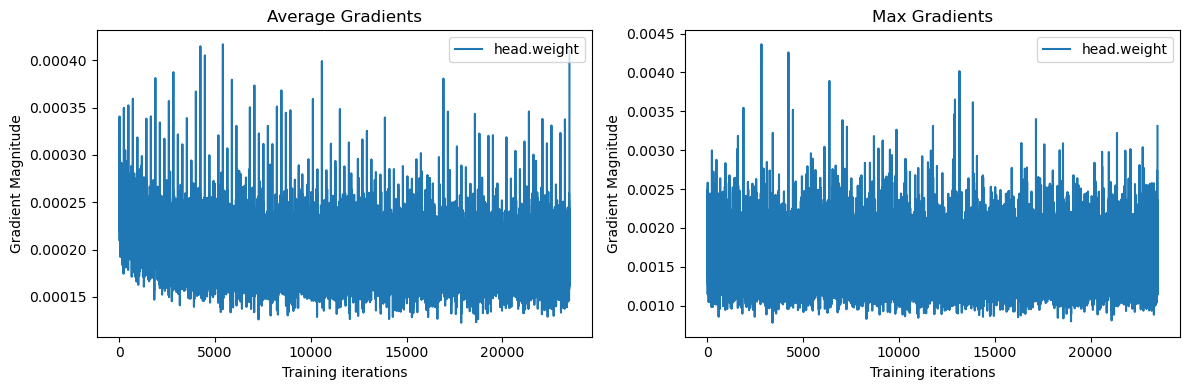

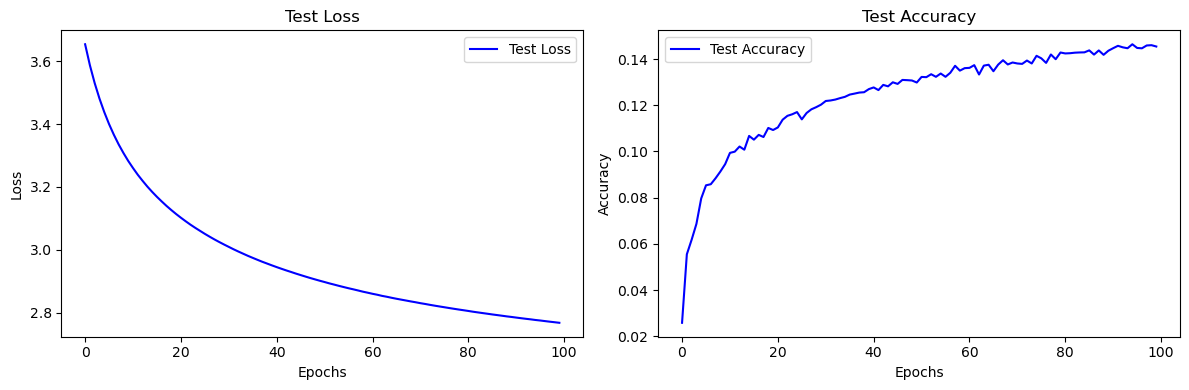

In [12]:
exp2.run(epochs=100)

accuracy on classes: 0.55415, accuracy on positions: 0.258225


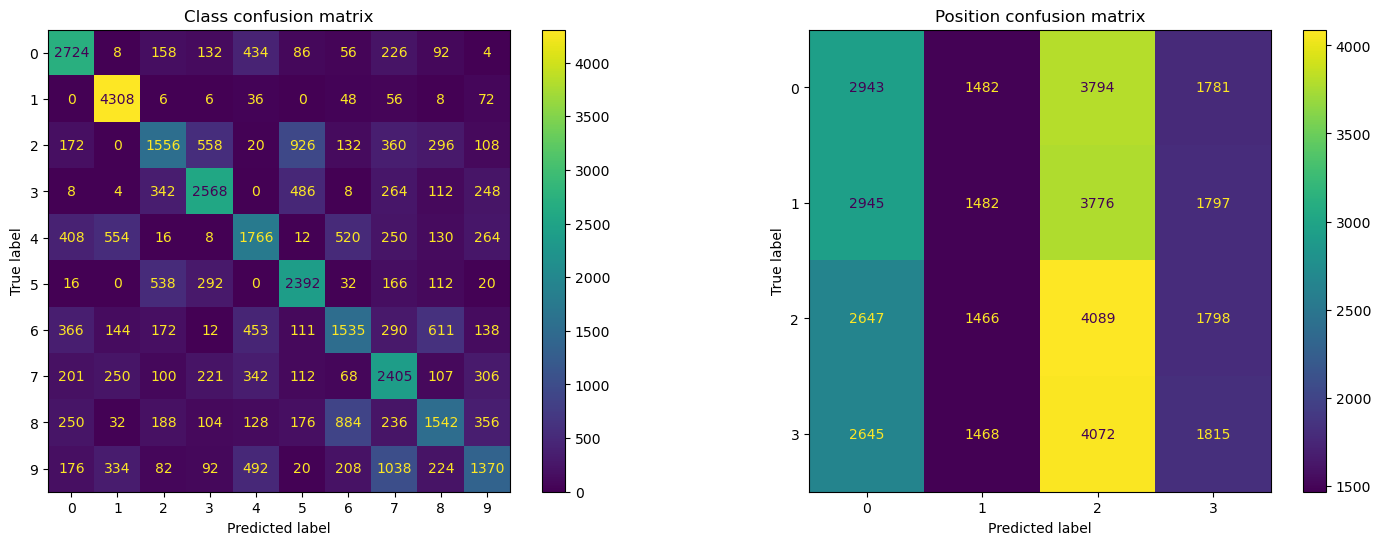

In [13]:
exp2.display_confusion_matrices()

In [14]:
modelHistogramPooling = CNNWithHistogramPooling(conv_out_channels=CONV_OUT_CHANNEL_SIZE, conv_kernel_size=2, num_of_bins=10, fc_out_size=fc_output_size, batch_size=BATCH_SIZE).to(device)
modelHistogramPooling.conv[0] = modelWithoutPooling.conv[0]
modelHistogramPooling.conv[1] = modelWithoutPooling.conv[1]
modelHistogramPooling.conv.apply(lambda m: set_requires_grad(m, False))

exp3 = MNISTExperiment(filtered_labels=label_filter, trainloader=trainloader, testloader=testloader, model=modelHistogramPooling, fc_out_size=fc_output_size, print_grad=True, clip_grad=True)

100%|██████████| 5/5 [45:19<00:00, 543.86s/it]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


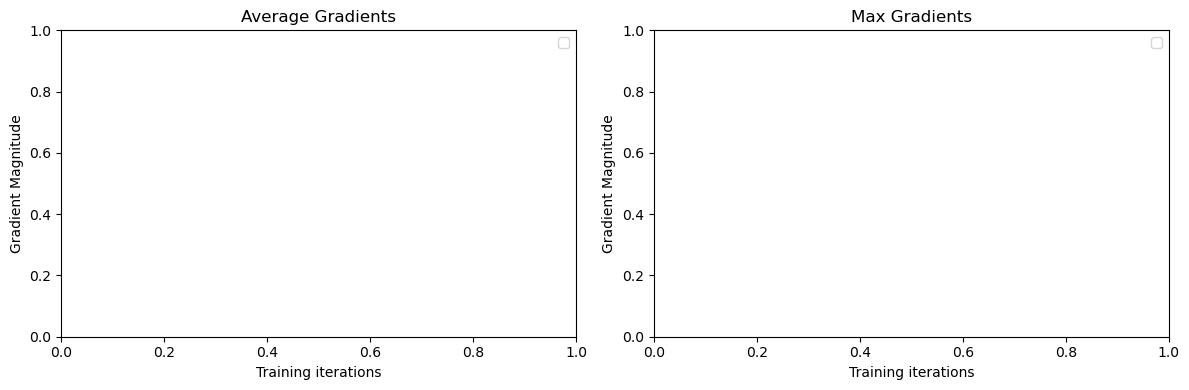

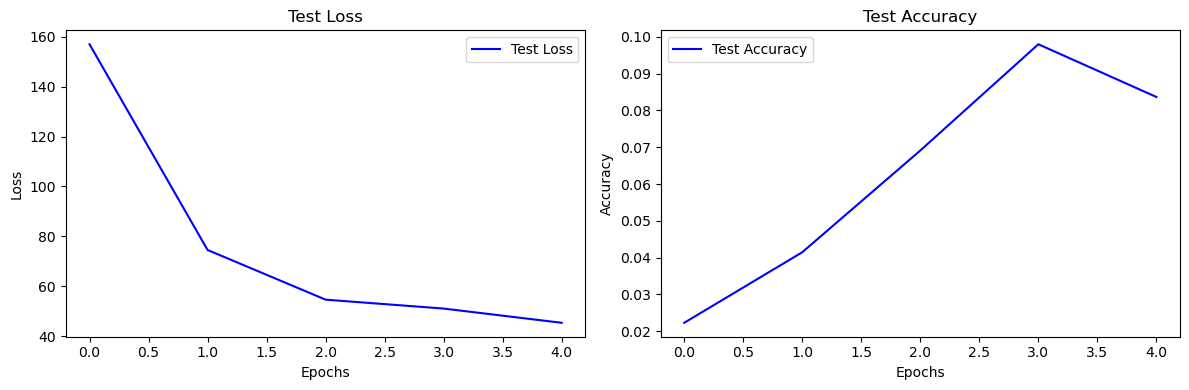

In [15]:
exp3.run(epochs=5)

accuracy on classes: 0.337375, accuracy on positions: 0.249575


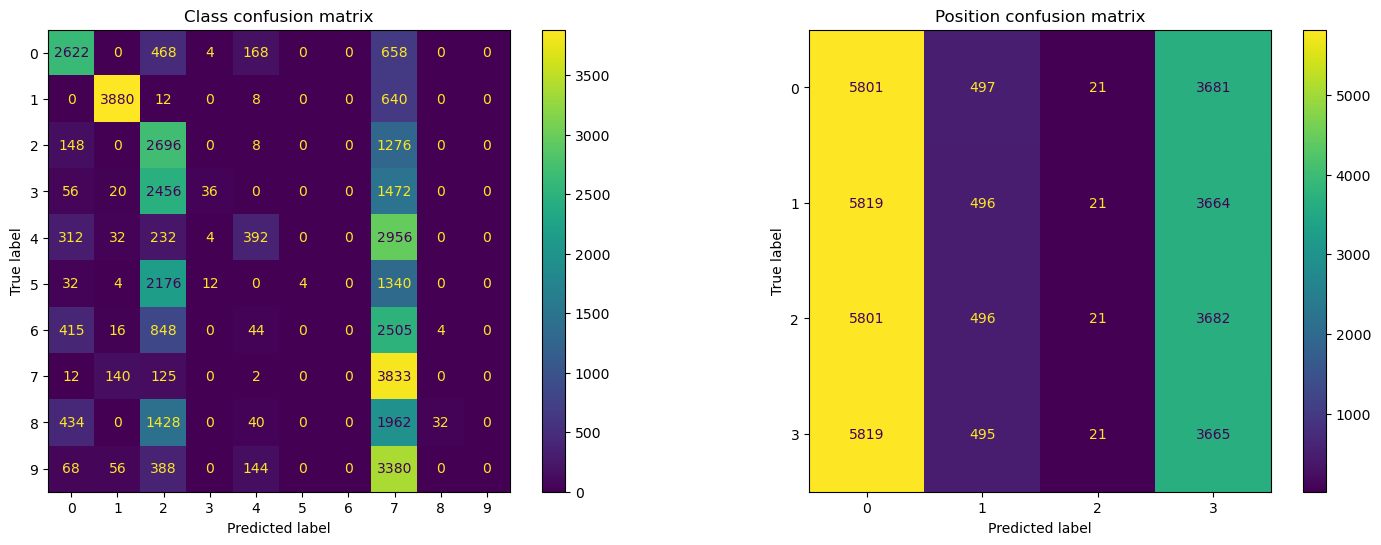

In [16]:
exp3.display_confusion_matrices()

In [17]:
modelHistogramPoolingV2 = CNNWithHistogramPooling(conv_out_channels=CONV_OUT_CHANNEL_SIZE, conv_kernel_size=2, num_of_bins=10, fc_out_size=fc_output_size, batch_size=BATCH_SIZE).to(device)
modelHistogramPoolingV2.conv[0] = modelWithoutPooling.conv[0]
modelHistogramPoolingV2.conv[1] = modelWithoutPooling.conv[1]
modelHistogramPoolingV2.conv.apply(lambda m: set_requires_grad(m, False))

exp3v2 = MNISTExperiment(filtered_labels=label_filter, trainloader=trainloader, testloader=testloader, model=modelHistogramPoolingV2, fc_out_size=fc_output_size, print_grad=True, clip_grad=True)

100%|██████████| 5/5 [36:49<00:00, 441.88s/it]


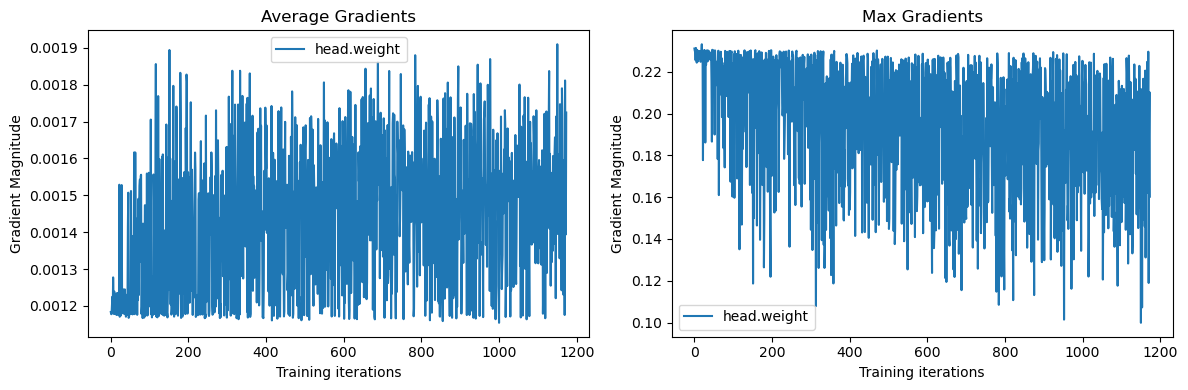

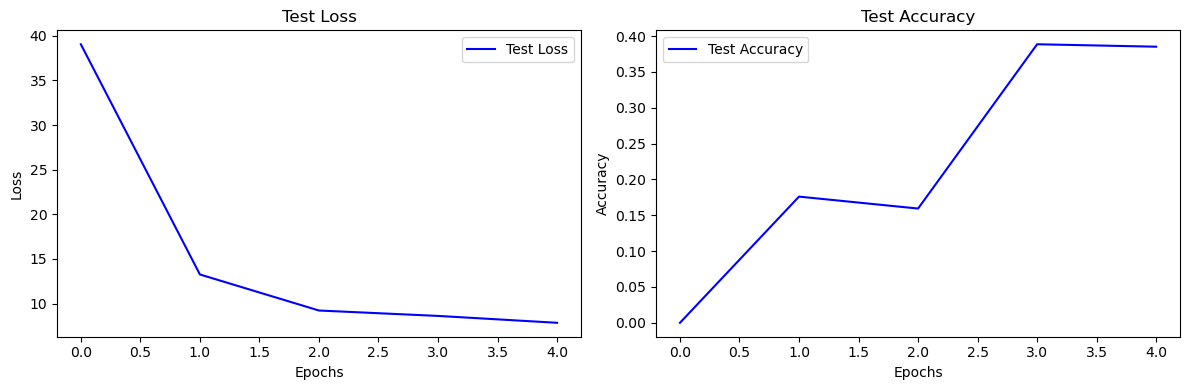

In [18]:
exp3v2.weird_run(epochs=5)

accuracy on classes: 0.07585, accuracy on positions: 0.24985


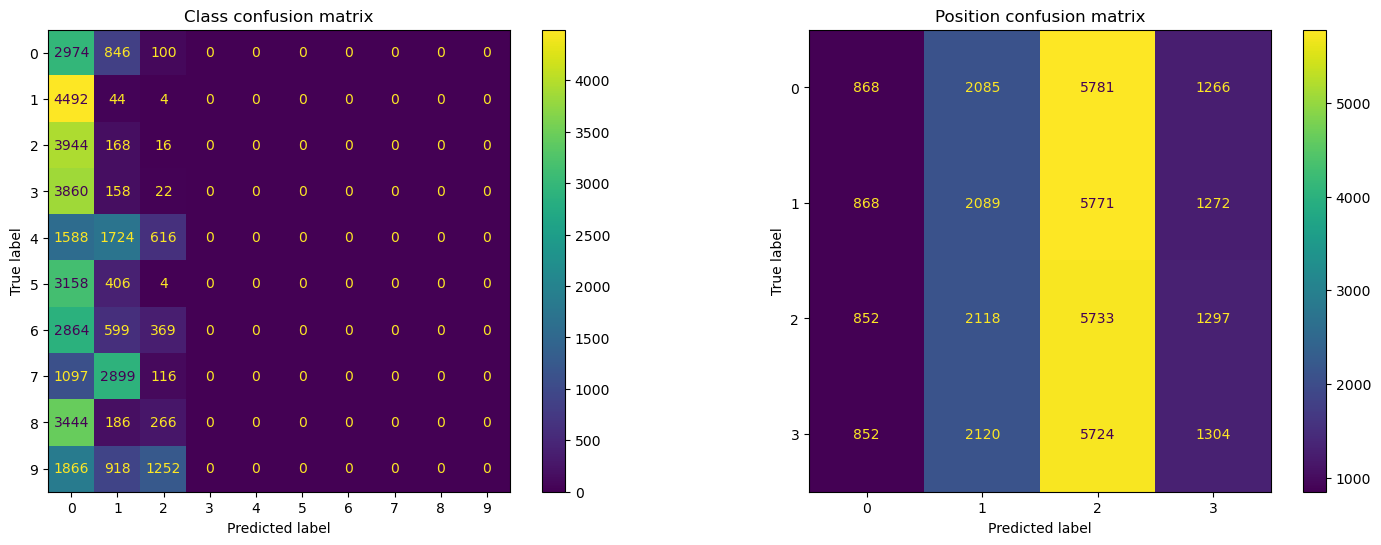

In [19]:
exp3v2.display_confusion_matrices()

100%|██████████| 5/5 [37:54<00:00, 454.98s/it]


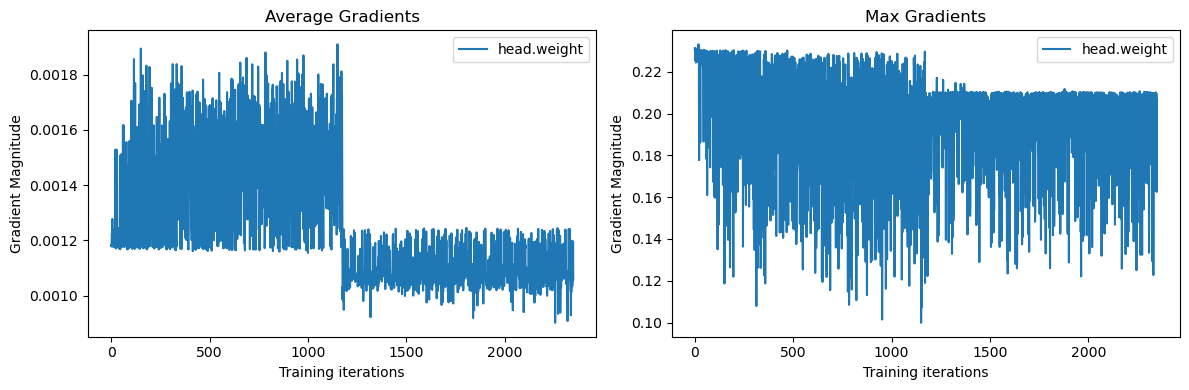

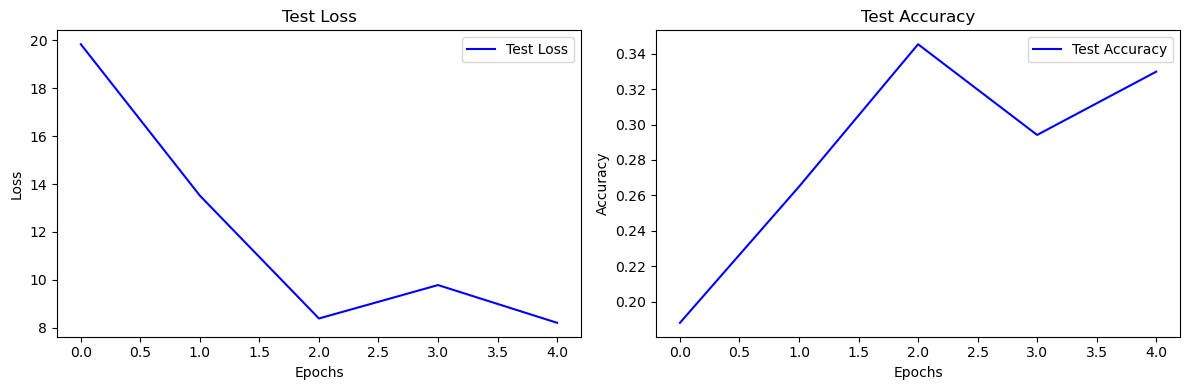

In [20]:
exp3v2.weird_run(epochs=5, digits=False)

accuracy on classes: 0.098, accuracy on positions: 0.25


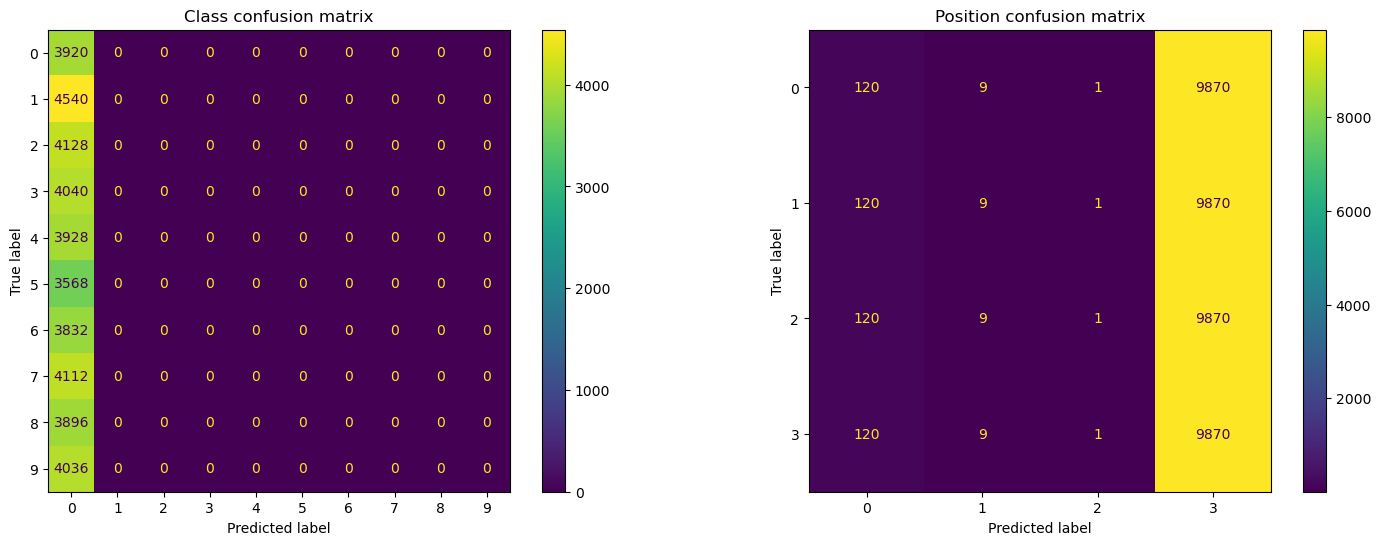

In [21]:
exp3v2.display_confusion_matrices()